# <div><span style="color: #ff98ab">P</span><span style="color: #ff9ba3">r</span><span style="color: #ff9e9a">o</span><span style="color: #ffa192">j</span><span style="color: #ffa489">e</span><span style="color: #ffa681">t</span><span style="color: #ffa978"> </span><span style="color: #ffac70">S</span><span style="color: #ffaf67">i</span><span style="color: #ffb66b">m</span><span style="color: #febd70">u</span><span style="color: #fec474">l</span><span style="color: #feca78">a</span><span style="color: #fed17c">t</span><span style="color: #fdd881">i</span><span style="color: #fddf85">o</span><span style="color: #f2dd86">n</span><span style="color: #e7db87"> </span><span style="color: #dcd888">N</span><span style="color: #d2d68a">u</span><span style="color: #c7d48b">m</span><span style="color: #bcd28c">é</span><span style="color: #b1cf8d">r</span><span style="color: #a6cd8e">i</span><span style="color: #a3cd97">q</span><span style="color: #9fcca0">u</span><span style="color: #9ccca9">e</span><span style="color: #99ccb2"> </span><span style="color: #96ccbb">E</span><span style="color: #92cbc4">N</span><span style="color: #8fcbcd">S</span><span style="color: #91c5cf">E</span><span style="color: #93bed1">E</span><span style="color: #95b8d3">I</span><span style="color: #98b2d5">H</span><span style="color: #9aabd6">T</span><span style="color: #9ca5d8"> </span><span style="color: #9e9eda">2</span><span style="color: #a098dc">0</span><span style="color: #a698dc">2</span><span style="color: #ac98dc">2</span><span style="color: #b298dc">-</span><span style="color: #b998dc">2</span><span style="color: #bf98dc">0</span><span style="color: #c598dc">2</span><span style="color: #cb98dc">3</span></div>
### $\textbf{Groupe}$     : 2SN B1 
### $\textbf{Nom}$        : CHEN
### $\textbf{Prénom}$     : Bryan
### Commentaire: 

# Informations pratiques

**Modalités pédagogiques** 

Le projet Simulation Numérique vise à vous faire découvrir un algorithme particulier en lien avec d'autres modules d'enseignement de cette année et d'illustrer certaines notions et propriétés à partir de programmes simples que vous devez écrire ou bien compléter. Le langage de programmation proposé est Python. Une connaissance basique de Python et de Numpy est suffisante. 

Cette année, il vous est demandé en premier lieu un travail de compréhension des algorithmes principaux sur la base du C/TD du 10/3/23 et des liens en fin de Notebook. Ensuite est demandé un travail d'implantation informatique simple (partie A) et quelques applications sur des images vous sont proposées (partie B). Ce travail est notamment guidé, des questions de compréhension sur les algorithmes sont posées en Partie C. La partie D vous permet d'implanter un algorithme populaire à titre de comparaison. Le volume de travail demandé est raisonnable.

**Préambule** L'objectif de ce projet est d'analyser quelques algorithmes de factorisation structurée (déterministe ou aléatoire) de matrices de grande taille. Nous nous intéressons à des algorithmes de factorisation dits "Interpolative Decomposition (ID)" ou "CUR-ID", où l'on cherche à approcher au mieux une matrice en un produit de matrices de rang faible. Les algorithmes seront comparés si possible sous différents angles: temps de calcul, complexité opératoire, précision numérique notamment. Nous envisagerons également l'utilisation d'algorithme dit de factorisation non-négative en fin de projet.

**NB:** Il vous est demandé d'insérer vos commentaires et codes **uniquement** dans ce fichier Notebook. Vous avez toute liberté pour créer des cellules soit de texte soit de code. Vous devez disposer comme données de ce fichier et de quelques images au format .jpg. Le rendu sera uniquement ce fichier Notebook dans lequel vous devez insérer l'ensemble de vos résultats. 

Ce projet est en lien notamment avec les cours suivants:

   * Calcul scientifique
   * Algèbre linéaire pour le data mining
   * Optimisation II

In [1]:
#
# Chargement des bibliotheques pour la visualisation, l'algebre lineaire et l'analyse du temps de calcul 
#
import matplotlib.pyplot as plt
import numpy as np
from   scipy import fftpack
from   scipy.linalg import qr, norm, solve_triangular, svd
from   PIL import Image
import time

### Introduction.

L'approximation de rang faible que nous utiliserons dans ce projet se base sur une connaissance du rang exact ou du rang approché de la matrice étudiée. A titre informatif, la méthode suivante vous permet d'obtenir une majoration du rang d'une matrice rectangulaire $A$ telle que $ \|A - Q Q^T A \|_F \le \epsilon \|A \|_F$, $\epsilon$ désignant une tolérance choisie par l'utilisateur. Cette méthode sera donc utile par la suite dans vos expérimentations numériques, aucune modification n'est a priori requise. 


In [2]:
def adaptive_rank_determination(A,epsilon,blocking=16,iteration_max=10):
    """
    Adaptive rank determination based on randomization
    We look for an orthogonal matrix Q such that 
    $\|A - Q Q^T A \|_F \le \epsilon \|A \|_F$
    where $\|.\|_F$ denotes the Frobenius norm.
    
    Reference: 
    Adapted from Section 12 of P.G. Martinsson, "Randomized methods for matrix computations", 2019, 
    ArXiv 1607.01649 [https://arxiv.org/pdf/1607.01649.pdf]. The original algorithm corresponds to 
    Figure 12. 
    
    Input: 
    - A:         matrix to be analysed [array type] (of shape (m,n))
    - epsilon:   relative threshold related to the accuracy of the projection (in the Frobenius norm) (0<= epsilon <= 1)
    - blocking:  blocking parameter to be used in the implementation (for efficiency reasons) [int]
    
    Output:
    - Q:         matrix with orthonormal columns such that $ \|A - Q Q^T A \|_F \le \epsilon \|A \|_F$
    - erank:     estimated rank (upper bound of epsilon-rank(A)), erank is here a multiple of min(blocking,n). 
    - ratio:     current ratio of $\|A - Q Q^T A \|_F4$ divided by $\|A \|_F$
    - iteration: nombre d'itérations réalisé au sein de l'algorithme
    """ 
    
    m, n          = A.shape[:]
    # The blocking parameter should be less than the number of columns
    b             = min(blocking,n) #pour des raisons d'efficacité
    iteration     = 0
    # Update the maximal number of iterations according to b
    iteration_max = max(np.ceil(n/b),iteration_max) 
    norm_A_Fro = norm(A,'fro')
    
    while norm(A,'fro') > epsilon*norm_A_Fro and iteration < iteration_max:
        
        # Create R the random block based on Gaussian variables
        R      = np.random.randn(n,b)
        # Matrix-matrix product Y = AR 
        Y      = A@R #produit matriciel numpy ( à la place de np.dot ) 
        # QR decomposition of Y
        QY, RY = qr(Y,mode='economic')
        # Compute the projection 
        BY     = QY.T@A #transpose(Q)*A
        
        # Concatenate the information related to Q and B
        if iteration == 0:
            Q  = QY
            B  = BY
        else:
            Q  = np.concatenate((Q, QY),axis=1)
            B  = np.concatenate((B, BY),axis=0)
        
        # Update the iteration count
        iteration += 1
        
        # Update of A
        A = A - QY@BY
        
        # Upper bound of epsilon-rank
        erank = Q.shape[1]
        
    return Q, Q.shape[1], norm(A,'fro')/norm_A_Fro, iteration

*h1*

## Partie A.1

Proposer une implantation des différents algorithmes de décomposition vus en cours. Pour vous aider, une définition des fonctions et leurs squelettes sont proposés. Vous avez toute liberté pour les modifier. Ces algorithmes seront utilisés dans la partie de validation (Partie B) et applicative du Notebook (Partie C). Vous pourrez vous appuyer sur les <a href="https://arxiv.org/pdf/1607.01649.pdf">chapitres 10 et 11 des notes de cours de P.G. Martinsson</a>:


In [3]:
#Pour AJ = QR = [Q1 Q2][R11 R12; 0 R22]
def column_ID(A,k):
    """
    Compute a column interpolative decomposition such that 
    A \approx A[:,J] Z
    
    Input: 
    - A:  matrix to be analysed [array] (of shape (m,n))
    - k:  estimated rank of matrix A [int]
    
    Output:
    - J:  is the set of column indices [array, any type] (of shape k)
    - Z:  is the corresponding matrix (of shape (k,n))
     
    Reference: 
    Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    
    m, n = A.shape[:]
    Z    = np.zeros(shape=(k,n))
    
    #
    # TO DO
    #
    # Perform the economic decomposition of A with column pivoting 
    [Q, S, J] = qr(A,mode='economic', pivoting = True)    
    
    # Deduce the T=R11^{-1}R12 block  
    T = solve_triangular(S[:k,:k],S[:k,k:n])
    
    # Deduce J and Z 
    #Z[:,J] = [np.eye(k), T]
    Z[:,J] = np.concatenate((np.eye(k),T), axis=1)
    J = J[:k]
    
    #
    # END TO DO
    #
    
    return J,Z


def row_ID(A,k):
    """
    Compute a row interpolative decomposition such that 
    A \approx X A[I,:] 
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    I  is the set of row indices [array, any type] (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    
    m, n = A.shape[:]
    X    = np.zeros(shape=(m,k))
    
    #
    # TO DO
    #
    
    # Perform the economic decomposition of A^T with column pivoting 
    [Q, S, J] = qr(A.T,mode='economic', pivoting = True)    
    
    # Deduce the T=R11^{-1}R12 block  
    T = solve_triangular(S[:k,:k],S[:k,k:m])
    
    # Deduce J and Z 
    X[J,:] = np.concatenate((np.eye(k),T), axis=1).T
    #X[J,:] = [np.eye(k), T].T
    I = J[:k]
    
        
    # Deduce the corresponding T block 
    
    
    
    # Deduce I and X 
    
    #
    # END TO DO
    #
    
    return I,X

def double_sided_ID(A,k):
    """
    Compute a double sided interpolative decomposition such that 
    A \approx X A(I,J) Z 
    
    Input: 
    A matrix to be analysed [array type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    I  is the set of row indices [array] (of shape k)
    J  is the set of column indices [array] (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    Z  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    #
    # TO DO
    #
    
    # Apply the column ID to A
    [J,Z] = column_ID(A,k)


    # Apply the row ID to A[:,J]
    [I,X] = row_ID(A[:,J],k)
    
    #
    # END TO DO
    #
    
    return I,J,X,Z

def extract_subblock(A,I,J):
    """
    Given a set of row and column indices, extract the submatrix 
    B = A[I,J]
    with I the set of row indices and J the set of column indices.
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    I  is the set of row indices  (of shape k)
    J  is the set of column indices  (of shape k)
    
    Output:
    Matrix A[I,J] [array] (of shape (k,k))
    """
    B = np.zeros(shape=(len(I),len(J)))
    row_index = 0
    
    for i in I:
        col_index = 0
        for j in J:
            B[row_index,col_index] = A[i,j]
            col_index = col_index + 1
            
        row_index = row_index + 1
    
    return B

def cur(A,k):
    """
    Deterministic version of the CUR algorithm based on the 
    double sided ID decomposition. 
    
    Input: 
    - A: matrix to be analysed [any type] (of shape (m,n))
    - k: estimated rank of matrix A [int]  
    
    Output:
    C  is the corresponding matrix (of shape (m,k))
    U  is the corresponding matrix (of shape (k,k))
    R  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 11.2 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    #
    # TO DO
    #
    
    # Apply the double sided interpolation algorithm 
    [I,J,X,Z] = double_sided_ID(A,k)
    
    
    # Deduce the C and R matrices of the CUR formulation 
    C = A[:,J]
    R = A[I,:]

    # Solve U R = Z in a least-squares sense
    
    U = Z @ np.linalg.pinv(R)
    
    #
    # END TO DO
    #
    return I,J,C,U,R

## Partie A.2 

Proposer une implantation des différents algorithmes aléatoires de décomposition vus en cours. Pour vous aider, une définition des fonctions et leurs squelettes sont proposés. Vous avez toute liberté pour les modifier. Ces algorithmes seront utilisés dans la partie de validation (Partie B) et applicative du Notebook (Partie D). Vous pourrez vous appuyer sur les <a href="https://arxiv.org/pdf/1607.01649.pdf">chapitres 10 et 11 des notes de cours de P.G. Martinsson</a>:


In [4]:
def randomized_row_ID(A,k,p=10,q=2):
    """
    Randomized version of the row ID to decompose matrix A into
    A \approx X A(I,:) 
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    k: estimated rank of matrix A [int]
    p: oversampling parameter (p=10 by default)
    q: number of power iterations (q=2 by default)
    
    Output:
    I  is the set of row indices  (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    
    Reference: Section 10.4 and Figure 8 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    
    """
    m, n = A.shape[:]
    X    = np.zeros(shape=(m,k)) 
    
    # Use the randomized variant to construct Y an approximation of A
    G    = np.random.randn(n,k+p)
    Y    = A@G
   
    #
    # TO DO
    #
   
    
    # Apply the row ID algorithm to Y
    for j in range (0,q):
        Yprime = A.T@Y
        Y = A@Yprime
    
    [I,X] = row_ID(Y,k)
    
    #
    # END TO DO
    #
    
    return I,X

   
def randomized_cur(A,k,p=10,q=2):
    """
    Randomized version of the CUR algorithm     
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    p: oversampling parameter (p=10 by default)
    q: number of power iterations (q=2 by default)  
    
    Output:
    C  is the corresponding matrix (of shape (m,k))
    U  is the corresponding matrix (of shape (k,k))
    R  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 11.2 and Figure 10 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """    
    m, n = A.shape[:]
    
    # Randomized version starts here
    # Use the randomized variant to construct Y an approximation of A
     
    G    = np.random.randn(k+p,m)
    Y    = G@A
    
    #
    # TO DO
    #
    
    for j in range (0,q):
        Z = Y@A.T
        Y = Z@A
      
    # Apply the column ID algorithm to Y 
    
    [J,Z] = column_ID(Y,k)   
   
    # Apply the row ID algorithm to A[:,J]
    
    [I,Z1] = row_ID(A[:,J],k) 
        
    # Deduce the CUR matrices (C, R and then U)
    
    C = A[:,J]
    R = A[I,:]

    # Solve U R = Z in a least-squares sense
    
    U = Z @ np.linalg.pinv(R)
    
    #I,J,C,U,R = cur(A[I,:],k)
    
    #
    # END TO DO
    #
    return I,J,C,U,R

(900, 1201)


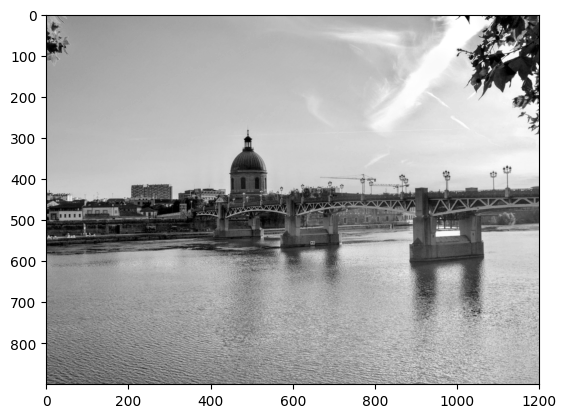

In [5]:
#######################################################################################################
#         ,----,                             ,--,                                                     # 
#       ,/   .`|  ,----..                 ,---.'|       ,----..                                       # 
#     ,`   .'  : /   /   \                |   | :      /   /   \                 .--.--.       ,---,. # 
#   ;    ;     //   .     :          ,--, :   : |     /   .     :          ,--, /  /    '.   ,'  .' | # 
# .'___,/    ,'.   /   ;.  \       ,'_ /| |   ' :    .   /   ;.  \       ,'_ /||  :  /`. / ,---.'   | # 
# |    :     |.   ;   /  ` ;  .--. |  | : ;   ; '   .   ;   /  ` ;  .--. |  | :;  |  |--`  |   |   .' # 
# ;    |.';  ;;   |  ; \ ; |,'_ /| :  . | '   | |__ ;   |  ; \ ; |,'_ /| :  . ||  :  ;_    :   :  |-, # 
# `----'  |  ||   :  | ; | '|  ' | |  . . |   | :.'||   :  | ; | '|  ' | |  . . \  \    `. :   |  ;/| # 
#     '   :  ;.   |  ' ' ' :|  | ' |  | | '   :    ;.   |  ' ' ' :|  | ' |  | |  `----.   \|   :   .' # 
#     |   |  ''   ;  \; /  |:  | | :  ' ; |   |  ./ '   ;  \; /  |:  | | :  ' ;  __ \  \  ||   |  |-, # 
#     '   :  | \   \  ',  / |  ; ' |  | ' ;   : ;    \   \  ',  / |  ; ' |  | ' /  /`--'  /'   :  ;/| # 
#     ;   |.'   ;   :    /  :  | : ;  ; | |   ,/      ;   :    /  :  | : ;  ; |'--'.     / |   |    \ # 
#     '---'      \   \ .'   '  :  `--'   \'---'        \   \ .'   '  :  `--'   \ `--'---'  |   :   .' # 
#                 `---`     :  ,      .-./              `---`     :  ,      .-./           |   | ,'   # 
#                            `--`----'                             `--`----'               `----'     # 
#######################################################################################################

                                                                                                  
# Lecture de l'image 
#
#
imgc = Image.open("toulouse.png")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M        = (1./255)*np.array(img_gray)
M_Sydney = M[:]
#
# Affichage de la taille de l'image et de l'image en gris si besoin
#
print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated epsilon-rank 1.2483165264129639
Estimated upper bound of the epsilon-rank:  256  for relative threshold:  0.05
Frobenius norm ratio:  0.04838019530503705  reached in  16 iterations
Time spent in the CUR algorithm 1.1322031021118164
Time spent in the randomized CUR algorithm 0.2793874740600586
Time spent in the double sided ID algorithm 0.502474308013916


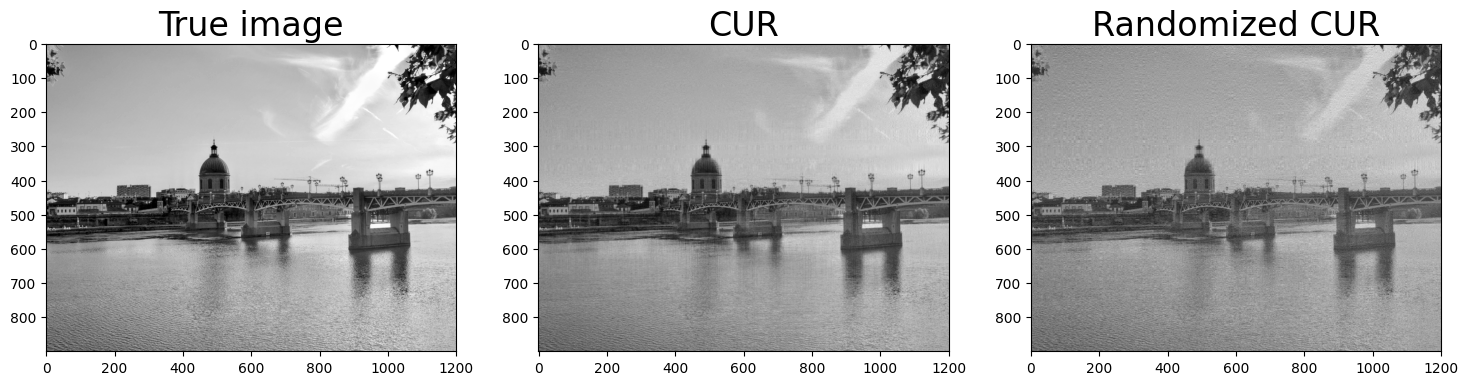

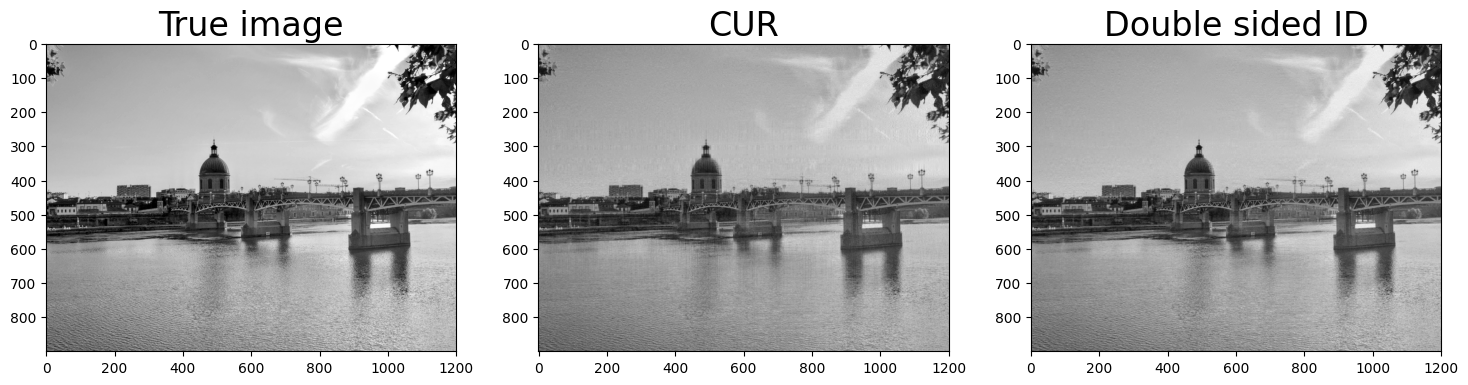

In [6]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
epsilon  = 0.05
#epsilon  = 5.e-2
blocking = 16
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
erank_Sydney = erank
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I, J, C, U, R  = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
#
# Double sided ID
#
t_start        = time.time()
I,J,X,Z        = double_sided_ID(M,erank)
JID_S          = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID_S,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

(1280, 1920)


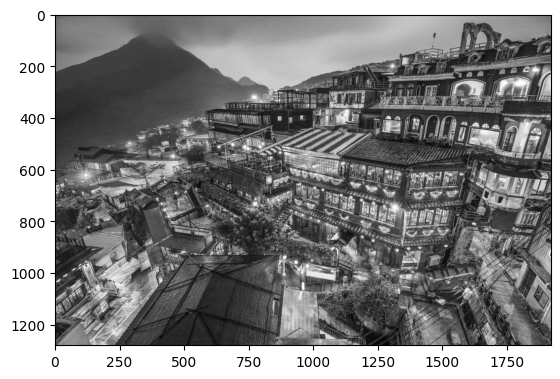

In [7]:
###############################################################
# '########::::'###::::'####:'##:::::'##::::'###::::'##::: ##:#
# ... ##..::::'## ##:::. ##:: ##:'##: ##:::'## ##::: ###:: ##:#
# ::: ##:::::'##:. ##::: ##:: ##: ##: ##::'##:. ##:: ####: ##:#
# ::: ##::::'##:::. ##:: ##:: ##: ##: ##:'##:::. ##: ## ## ##:#
# ::: ##:::: #########:: ##:: ##: ##: ##: #########: ##. ####:#
# ::: ##:::: ##.... ##:: ##:: ##: ##: ##: ##.... ##: ##:. ###:#
# ::: ##:::: ##:::: ##:'####:. ###. ###:: ##:::: ##: ##::. ##:#
# :::..:::::..:::::..::....:::...::...:::..:::::..::..::::..::#
###############################################################
#
# Lecture de l'image 
#
#
imgc = Image.open("taipei.jpg")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M        = (1./255)*np.array(img_gray)
M_Sydney = M[:]
#
# Affichage de la taille de l'image et de l'image en gris si besoin
#
print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated epsilon-rank 2.90883731842041
Estimated upper bound of the epsilon-rank:  592  for relative threshold:  0.05
Frobenius norm ratio:  0.04726638887035309  reached in  37 iterations
Time spent in the CUR algorithm 3.120495557785034
Time spent in the randomized CUR algorithm 2.810464859008789
Time spent in the double sided ID algorithm 2.6731367111206055


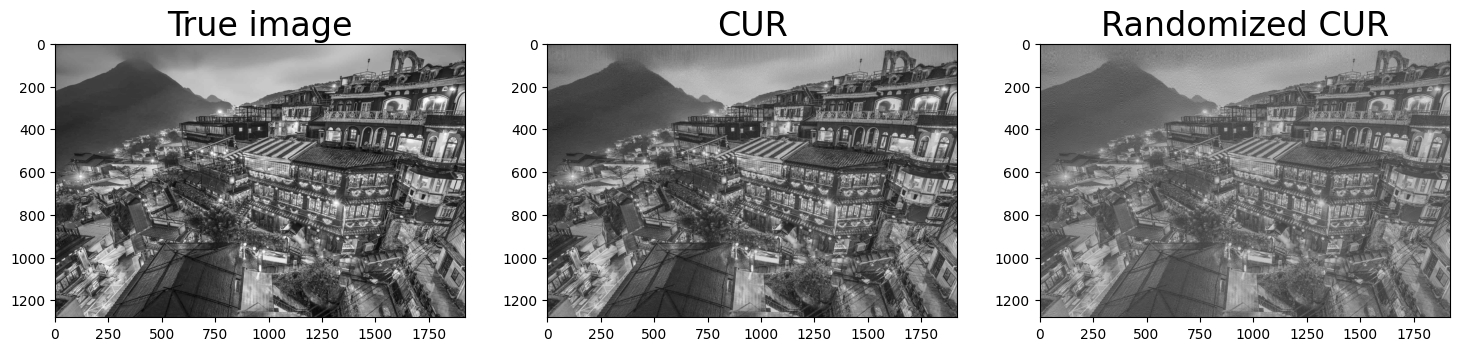

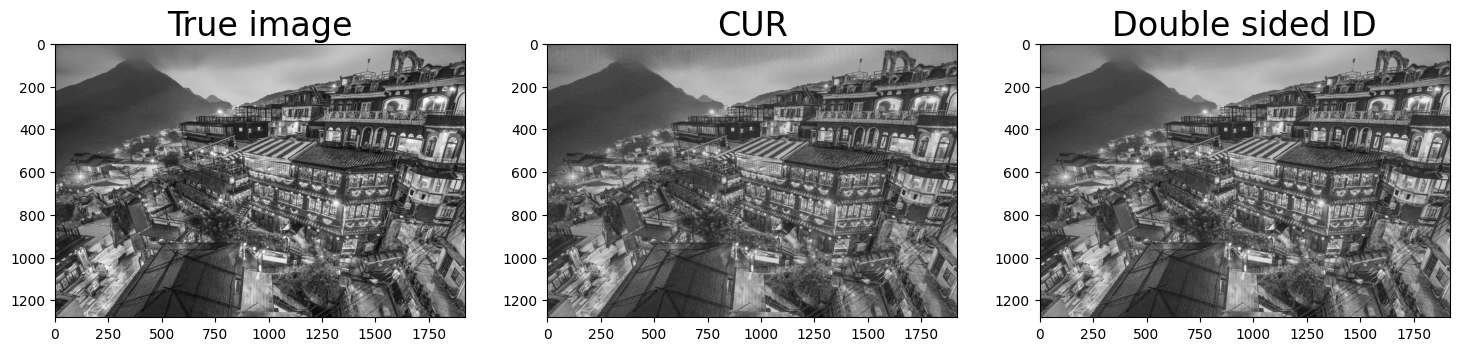

In [8]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
epsilon  = 0.05
#epsilon  = 5.e-2
blocking = 16
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
erank_Sydney = erank
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I, J, C, U, R  = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
#
# Double sided ID
#
t_start        = time.time()
I,J,X,Z        = double_sided_ID(M,erank)
JID_S          = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID_S,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

## Partie B

Nous cherchons à mettre en oeuvre les algorithmes précédents sur une application liée à la reconstruction d'images.
La cellule suivante vous montre comment charger une image et en déduire la matrice associée. Appliquer alors les algorithmes de 
factorisation vus en Partie A et visualiser les images obtenues en fonction du rang estimé.  

### Sydney

(396, 563)


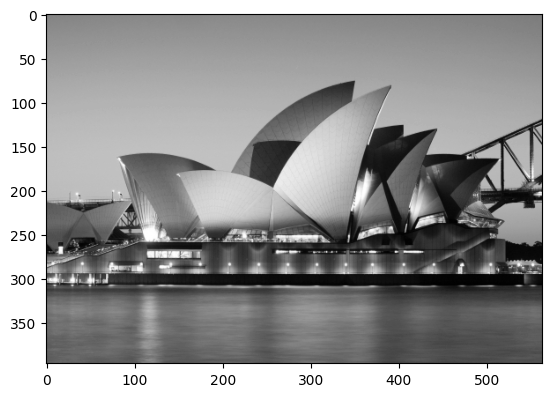

In [9]:
#
# Lecture de l'image 
#
#
imgc = Image.open("Sydney_Opera_House.jpg")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M        = (1./255)*np.array(img_gray)
M_Sydney = M[:]
#
# Affichage de la taille de l'image et de l'image en gris si besoin
#
print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated epsilon-rank 0.2062549591064453
Estimated upper bound of the epsilon-rank:  96  for relative threshold:  0.05
Frobenius norm ratio:  0.04238041986817856  reached in  6 iterations
Time spent in the CUR algorithm 0.22856450080871582
Time spent in the randomized CUR algorithm 0.17192316055297852
Time spent in the double sided ID algorithm 0.26777052879333496


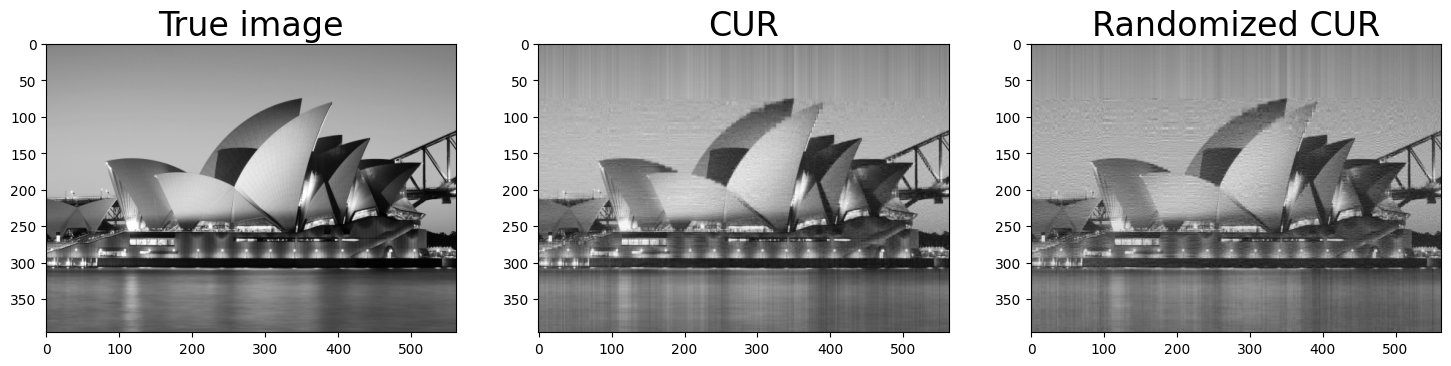

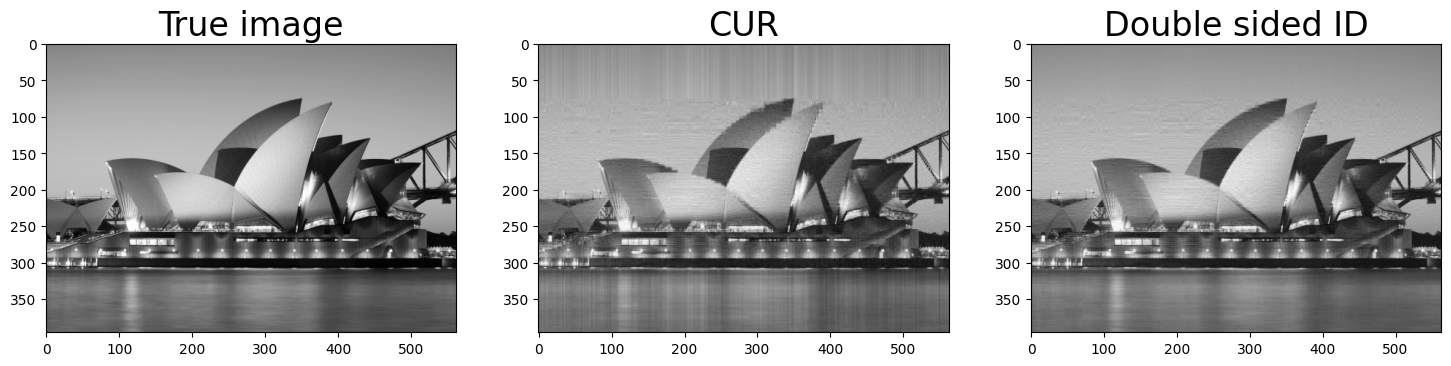

In [10]:
################################################################
# :'######::'##:::'##:'########::'##::: ##:'########:'##:::'##:#
# '##... ##:. ##:'##:: ##.... ##: ###:: ##: ##.....::. ##:'##::#
#  ##:::..:::. ####::: ##:::: ##: ####: ##: ##::::::::. ####:::#
# . ######::::. ##:::: ##:::: ##: ## ## ##: ######:::::. ##::::#
# :..... ##:::: ##:::: ##:::: ##: ##. ####: ##...::::::: ##::::#
# '##::: ##:::: ##:::: ##:::: ##: ##:. ###: ##:::::::::: ##::::#
# . ######::::: ##:::: ########:: ##::. ##: ########:::: ##::::#
# :......::::::..:::::........:::..::::..::........:::::..:::::#
################################################################
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
epsilon  = 0.05
#epsilon  = 5.e-2
blocking = 16
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
erank_Sydney = erank
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I, J, C, U, R  = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
#
# Double sided ID
#
t_start        = time.time()
I,J,X,Z        = double_sided_ID(M,erank)
JID_S          = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID_S,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

### Tokyo

(1008, 1212)


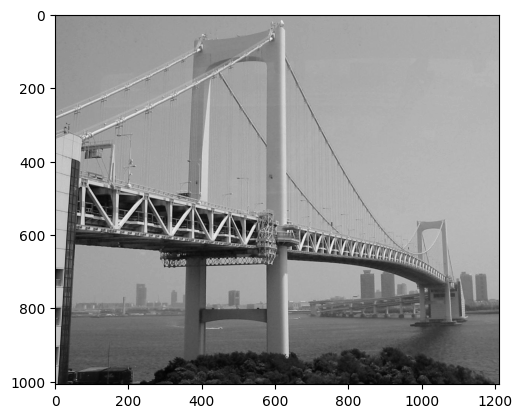

In [11]:
#######################################################
# '########::'#######::'##:::'##:'##:::'##::'#######::#
# ... ##..::'##.... ##: ##::'##::. ##:'##::'##.... ##:#
# ::: ##:::: ##:::: ##: ##:'##::::. ####::: ##:::: ##:#
# ::: ##:::: ##:::: ##: #####::::::. ##:::: ##:::: ##:#
# ::: ##:::: ##:::: ##: ##. ##:::::: ##:::: ##:::: ##:#
# ::: ##:::: ##:::: ##: ##:. ##::::: ##:::: ##:::: ##:#
# ::: ##::::. #######:: ##::. ##:::: ##::::. #######::#
# :::..::::::.......:::..::::..:::::..::::::.......:::#
#######################################################
#
# Lecture de l'image 
#
#
#imgc = Image.open("Sydney_Opera_House.jpg")
imgc = Image.open("Tokyo_Rainbow_Bridge.jpg")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M        = (1./255)*np.array(img_gray)
M_Tokyo  = M[:]
#
# Affichage de la taille de l'image et de l'image en gris si besoin
#
print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated epsilon-rank 0.27879762649536133
Estimated upper bound of the epsilon-rank:  160  for relative threshold:  0.05
Frobenius norm ratio:  0.046764153982920845  reached in  10 iterations
Time spent in the CUR algorithm 0.7293398380279541
Time spent in the randomized CUR algorithm 0.19406628608703613
Time spent in the double sided ID algorithm 0.6612968444824219


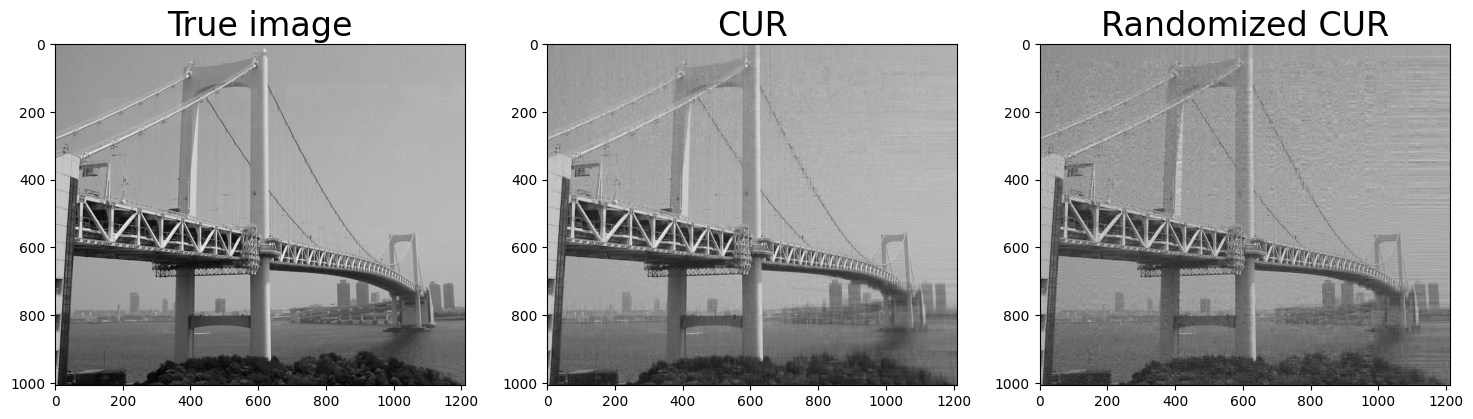

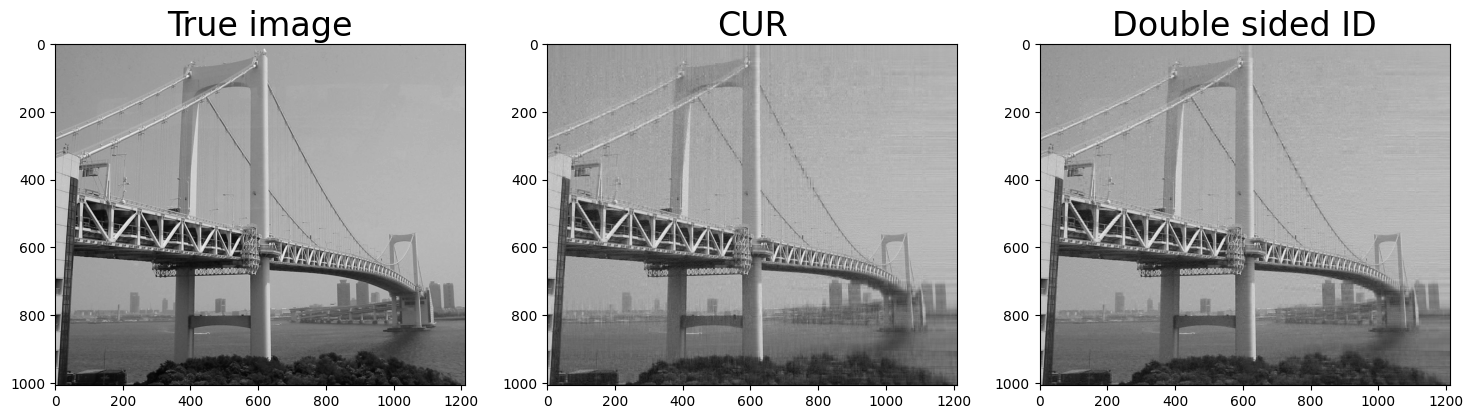

In [12]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
epsilon = 0.05
#epsilon  = 5.e-2
blocking = 16
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
erank_Tokyo = erank
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I, J, C, U, R  = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
#
# Double sided ID
#
t_start        = time.time()
I,J,X,Z        = double_sided_ID(M,erank)
JID_T          = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID_T,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

### Hamburg

(524, 932)


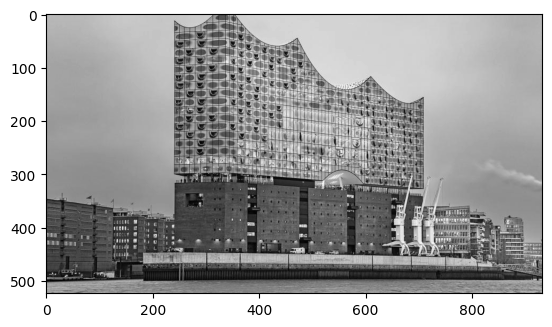

In [13]:
################################################################################
# '##::::'##::::'###::::'##::::'##:'########::'##::::'##:'########:::'######:::#
#  ##:::: ##:::'## ##::: ###::'###: ##.... ##: ##:::: ##: ##.... ##:'##... ##::#
#  ##:::: ##::'##:. ##:: ####'####: ##:::: ##: ##:::: ##: ##:::: ##: ##:::..:::#
#  #########:'##:::. ##: ## ### ##: ########:: ##:::: ##: ########:: ##::'####:#
#  ##.... ##: #########: ##. #: ##: ##.... ##: ##:::: ##: ##.. ##::: ##::: ##::#
#  ##:::: ##: ##.... ##: ##:.:: ##: ##:::: ##: ##:::: ##: ##::. ##:: ##::: ##::#
#  ##:::: ##: ##:::: ##: ##:::: ##: ########::. #######:: ##:::. ##:. ######:::#
# ..:::::..::..:::::..::..:::::..::........::::.......:::..:::::..:::......::::#
################################################################################
#
# Lecture de l'image [couleur] 
#
#
imgc = Image.open("Hamburg_Elbphilarmonie.jpg")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M         = (1./255)*np.array(img_gray)
M_Hamburg = M[:]

print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated epsilon-rank 0.29403090476989746
Estimated upper bound of the epsilon-rank:  272  for relative threshold:  0.05
Frobenius norm ratio:  0.047374105341696435  reached in  17 iterations
Time spent in the CUR algorithm 0.20903706550598145
(272, 932)
Time spent in the randomized CUR algorithm 0.19027304649353027
(272, 932)
Time spent in the double sided ID algorithm 0.18748044967651367
(272, 932)


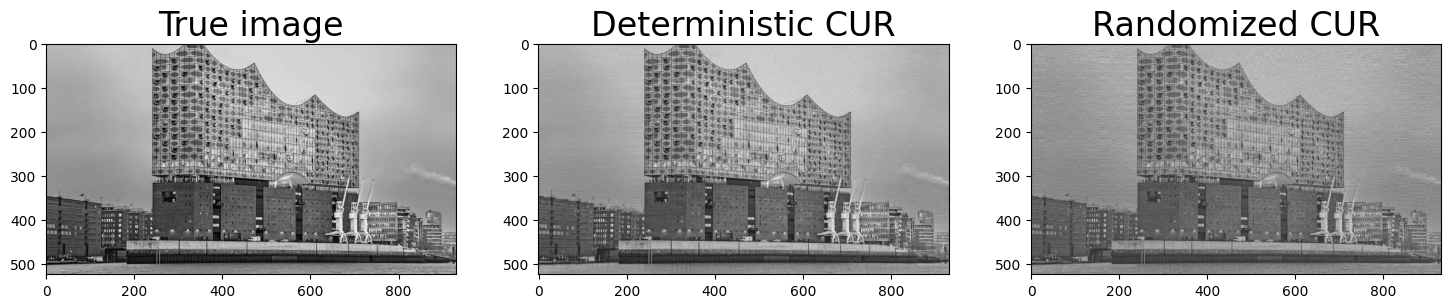

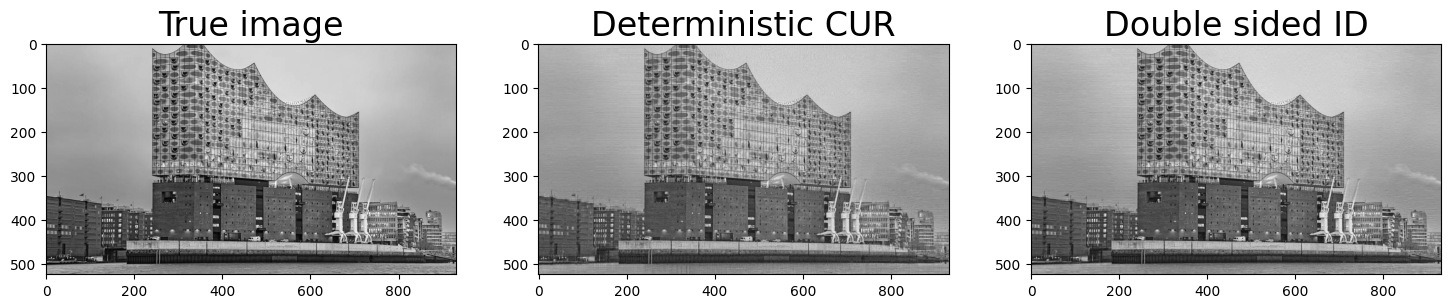

In [14]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
erank_Hamburg = erank
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
print(np.shape(R))
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I,J,C, U, R    = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
print(np.shape(R))
#
# Double sided ID
#
t_start  = time.time()
I,J,X,Z  = double_sided_ID(M,erank)
JID_H    = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
print(np.shape(Z))
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('Deterministic CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('Deterministic CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID_H,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

**Question:**
* B.1 Prenez trois valeurs pour $\epsilon$ (par exemple $\epsilon=0.5$, $\epsilon=0.1$ et $\epsilon=0.05$) et analysez la qualité de l'approximation pour les images considérées. Qu'observez-vous ? 

**Réponse**:

Plus $\epsilon$ est faible, meilleure est l'approximation pour les images considérées. En effet, on a les exemples ci-dessous : 

- Pour $\epsilon=0.5$, la qualité de l'approximation pour les images considérées est moins bonne que pour 5.e-2 [flou] (CUR, Randomized CUR et Double sided ID) (par rapport à l'image réelle)
- Pour $\epsilon=0.1$, la qualité de l'approximation pour les images considérées est bien meilleure que pour $\epsilon=0.5$ [moins flou que pour $\epsilon=0.5$]
- Pour $\epsilon=0.05$, la qualité de l'approximation pour les images considérées est bien meilleure que pour $\epsilon=0.1$, la qualité des images du CUR et du Randomized CUR est très proche de l'image réelle.

**Question:**
* B.2 Observez-vous des différences de qualité de reconstruction entre les algorithmes pour une précision identique ?

**Réponse**:

Pour une précision identique, les différences de qualité de reconstruction entre les algorithmes sont en effet différents, puisque Randomized CUR a la moins bonne qualité, puis s'ensuit l'algorithme Deterministic CUR et enfin l'approximation avec la meilleure qualité de l'approximation est double sided ID. 

De manière plus détaillée:

- Comparaison CUR et Randomized CUR : 

L'algorithme Randomized CUR est plus précis que la méthode CUR traditionnelle lorsqu'il s'agit de produire une image avec le même niveau de détail. Cependant, pour des images de plus en plus grandes, l'algorithme Randomized CUR devient plus rapide que la technique classique C UR. Le processus de calcul est plus long pour une valeur q plus élevée avec cette stratégie et, par extension, la qualité de l'image diminue au fur et à mesure que q augmente

- Comparaison CUR et double sided ID : 

L'application de la méthode CUR pour la reconstruction de l'image ne conduit pas à une récupération complète des gradients de couleur, tandis que la mise en œuvre de la double décomposition aboutit à une image très similaire avec un contraste légèrement inférieur à celui de l'image d'origine.

La méthode de double décomposition est initialement plus rapide que la méthode CUR pour toutes les tailles d'image, et la différence ne commence à se creuser qu'avec une augmentation de la précision (c'est-à-dire lorsque le paramètre epsilon diminue).



## Partie C.

En vous basant notamment sur les notes de cours, le chapitre 11 de <a href="https://arxiv.org/pdf/1607.01649.pdf">Martinsson (2019)</a>, la section 13 de <a href="https://arxiv.org/pdf/2002.01387.pdf">Martinsson et Tropp (2020)</a>,  répondre aux deux questions suivantes:

* C.1 Donner les avantages et inconvénients éventuels de la décomposition déterministe CUR-ID. 

**Réponse**:

Les avantages éventuels de la décomposition déterminsite CUR-ID est que : efficace et rapide.
Les inconvénients de la décomposition déterminsite CUR-ID : pas de parallélisation possible et complexité pas aussi intéressante.

* C.2 Expliquer comment paralléliser l'algorithme aléatoire CUR-ID. 

**Réponse**:

Afin de paralléliser l'algorithme aléatoire de CUR-ID, il faudrait : ...

## Partie D.

Appliquer l'algorithme de factorisation non-négative de <a href="https://proceedings.neurips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf">Lee et Cheung</a> (Théoreme 1) pour obtenir une approximation d'une image donnée en norme de Frobenius. Une attention sera donnée à l'implantation proposée et au temps de restitution obtenu.  Vous pourrez à cet effet utiliser les fonctions multiply et divide de NumPy.

In [15]:
def nmf(M,erank,epsilon,iteration_max):
    
    """
    Non-negative matrix factorization for matrix M.
    
    Input: 
    M:             matrix to be analysed [array type] (of shape (m,n))
    erank:         estimated rank (upper bound of epsilon-rank(M))
    epsilon:       relative threshold related to the accuracy of the projection (in the Frobenius norm) (0<= epsilon <= 1)
    iteration_max: maximal number of iterations [int]
    
    Output:
    X,Y:           matrices with positive entries such that $ \|M - X Y \|_F \le \epsilon \|M \|_F$
    iteration:     effective number of iterations
    """
    
    m     = np.shape(M)[0] # nombre de lignes de la matrice M
    n     = np.shape(M)[1] # nombre de colonnes de la matrice M
    
    # Specify two possible first iterates for X and Y
    X = np.random.rand(m,erank) 
    Y = np.random.rand(erank,n)

    #X = np.ones((m,erank))
    #Y = np.ones((erank,n))
    # Set variables
    norm_A_Fro    = norm(M,'fro')
    iteration     = 0
    
    # Algorithm 
    while norm(M-X@Y,'fro') > epsilon*norm_A_Fro and iteration < iteration_max:
        #
        # TO DO
        #
        
        Y = np.multiply(Y,np.divide(X.T@M,X.T@X@Y))
        X = np.multiply(X, np.divide(M@Y.T,X@Y@Y.T))
        #Y = Y1
        
        iteration = iteration + 1
        #
        # END TO DO
        #
        if iteration%25 == 0:
            print(iteration,norm(M-X@Y,'fro')/norm_A_Fro)

    return X,Y,iteration

25 0.22679948878889597
50 0.1770806356832266
75 0.14629538119330182
100 0.1255937349652961
125 0.11210071125273985
150 0.10272611938562216
175 0.0958078454170916
200 0.09047512328072672
225 0.08624161989343251
250 0.08280193984063097
275 0.07995383477497768
300 0.07755506800322522
325 0.07550271666288651
350 0.07372294660843152
375 0.07216230445633112
400 0.07078115432986604
425 0.06954914710870268
450 0.068442374576429
475 0.06744171875547095
500 0.06653174135233299
525 0.06569990562156229
550 0.06493606561892128
575 0.06423197402586843
600 0.0635809538059551
625 0.06297712351737264
650 0.06241523765279864
675 0.061890708580292705
700 0.06139961506247602
725 0.06093866096711891
750 0.060505106191675276
775 0.060096637774989484
800 0.05971120005615992
825 0.05934689605741308
850 0.05900197040608705
875 0.05867483104013255
900 0.05836406075584806
925 0.058068400226121246
950 0.05778670692711086
975 0.05751793312033164
1000 0.05726112922688533
1025 0.05701544141465416
1050 0.056780089722

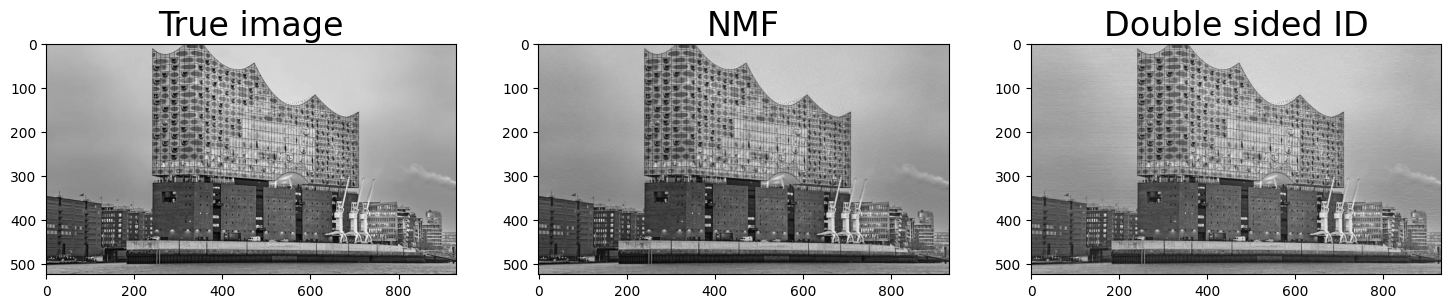

In [16]:
#
# Specify one of the target images here
#
erank = erank_Hamburg
M     = M_Hamburg[:]
JID   = JID_H[:]
#
# NMF 
#
iteration_max = 3500
epsilon       = 0.05
t_start       = time.time()
X,Y,iteration = nmf(M,erank,epsilon,iteration_max)
print("Time spent in the non-negative matrix factorization (NMF)",time.time()-t_start)
print("Norm ratio: ",norm(M-X@Y,'fro')/norm(M,'fro'), " reached in ", iteration, "iterations") 
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(X@Y,'gray')
plt.title('NMF',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

25 0.20435540248076653
50 0.1295690091294023
75 0.10187769366527936
100 0.08723405428295287
125 0.07778334763255663
150 0.07114034278824449
175 0.06624797543719194
200 0.06252094630018834
225 0.05959975645039188
250 0.057247515402136545
275 0.055306340885949774
300 0.05366965784879906
325 0.05226524195548137
350 0.05104395527814409
375 0.04997061104776277
Time spent in the non-negative matrix factorization (NMF) 5.124783754348755
Norm ratio:  0.04997061104776277  reached in  375 iterations


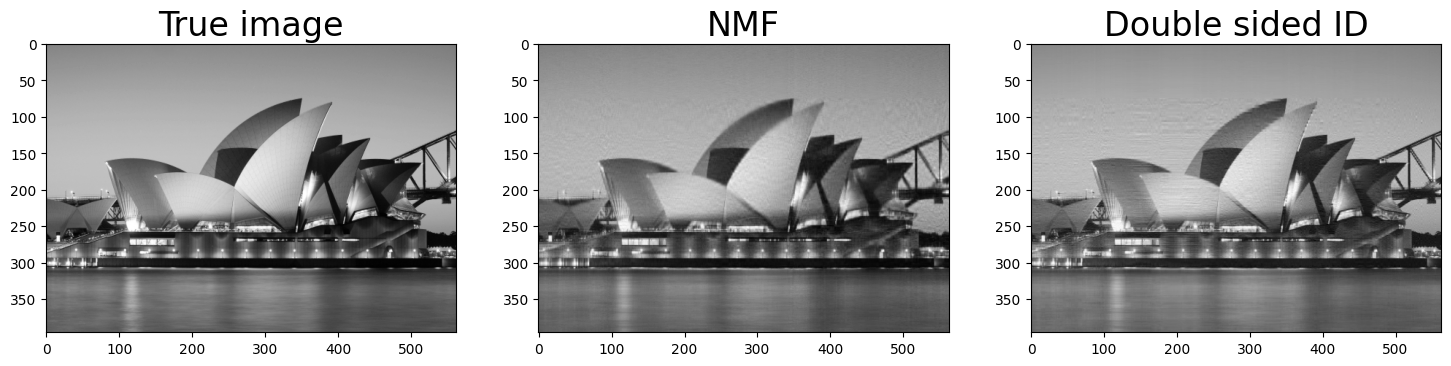

In [17]:
#
# Specify one of the target images here
#
erank = erank_Sydney
M     = M_Sydney[:]
JID   = JID_S[:]
#
# NMF 
#
iteration_max = 2000
epsilon       = 0.05
t_start       = time.time()
X,Y,iteration = nmf(M,erank,epsilon,iteration_max)
print("Time spent in the non-negative matrix factorization (NMF)",time.time()-t_start)
print("Norm ratio: ",norm(M-X@Y,'fro')/norm(M,'fro'), " reached in ", iteration, "iterations") 
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(X@Y,'gray')
plt.title('NMF',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

25 0.20086531470626148
50 0.1564513761774903
75 0.12845355267303754
100 0.10781765777302073
125 0.09430937790869068
150 0.08542300593038828
175 0.07915778498228199
200 0.07444534188206152
225 0.07073538034183889
250 0.06771826377826055
275 0.06519882094572871
300 0.06304919134999516
325 0.061187161417713416
350 0.059556511169558124
375 0.058116317782398216
400 0.05683545739943449
425 0.055689519916886164
450 0.054658687682696945
475 0.053726564719630464
500 0.0528795750641926
525 0.05210651315071494
550 0.05139804676568306
575 0.05074624758458823
600 0.050144343541340924
Time spent in the non-negative matrix factorization (NMF) 56.27700400352478
Norm ratio:  0.049983945833706654  reached in  607 iterations


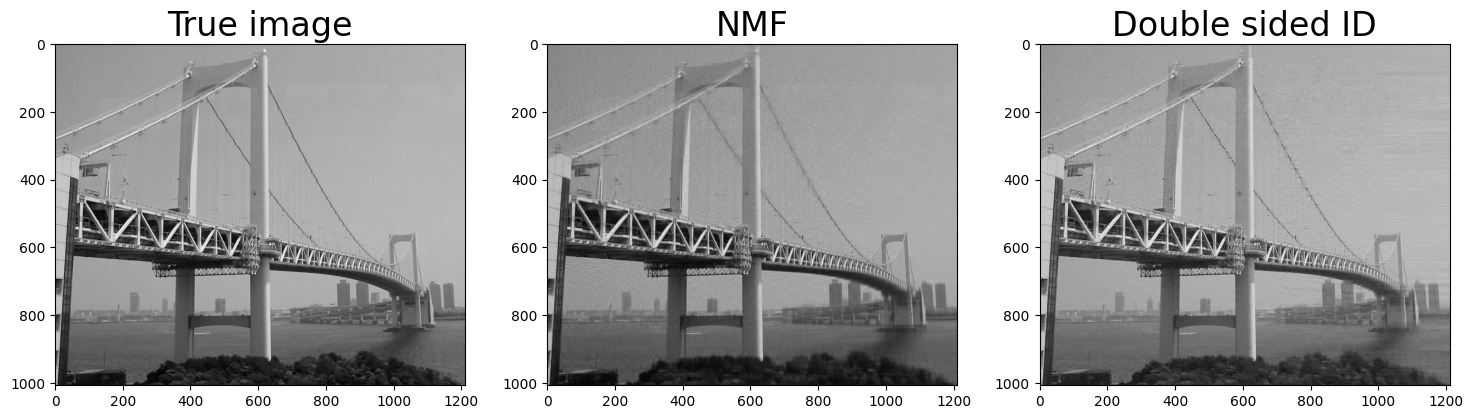

In [18]:
#
# Specify one of the target images here
#
erank = erank_Tokyo
M     = M_Tokyo[:]
JID   = JID_T[:]
#
# NMF 
#
iteration_max = 2000
epsilon       = 0.05
t_start       = time.time()
X,Y,iteration = nmf(M,erank,epsilon,iteration_max)
print("Time spent in the non-negative matrix factorization (NMF)",time.time()-t_start)
print("Norm ratio: ",norm(M-X@Y,'fro')/norm(M,'fro'), " reached in ", iteration, "iterations") 
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(X@Y,'gray')
plt.title('NMF',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

### Questions:

* D.1 Pour $\epsilon=0.05$, indiquer pour chacune des images le temps de restitution et le nombre d'itérations. Commenter la vitesse de convergence de la méthode et la qualité de l'image reconstruite.

**Réponse**:

Pour $\epsilon=0.05$, pour : 

- l'image Hamburg  : 3076 itérations avec un temps de restitution de 51.0134437084198  avec norm_ratio : 0.04999870055903614 [quality]
- l'image Sydney   : 340 itérations avec un temps de restitution de 1.4403069019317627 avec norm_ratio : 0.04999304184318832 [quality]
- l'image Tokyo    : 596 itérations avec un temps de restitution de 13.767113208770752 avec norm_ratio : 0.04998447898086941 [quality]

La vitesse de convergence de la méthode dépend de l'image, elle est plus rapide pour Sydney que pour les autres villes. 

La qualité de l'image reconstruite est nette pour la méthode NMF avec l'image Hamburg, Sydney et Tokyo.

* D.2 A chaque fois, nous avons considéré une image exacte dans chacun des algorithmes pour en déduire une approximation de rang faible. Comment obtenir une approximation de rang faible si l'on dispose uniquement d'une image de qualité médiocre comme image initiale ? Proposez un algorithme. 

**Réponse**:

Si l'on dispose uniquement d'une image de qualité médiore comme image initiale, afin d'obtenir une approximation de rang faible, on utilise un algorithme d'optimisation, comme l'algorithme avec la méthode des sous-gradients. 

* Bonus : Quel(s) algorithme(s) utiliseriez-vous pour approcher (au sens de l'approximation de rang faible) non pas une image mais une séquence d'images (donnée par exemple au sein d'une video) ? 

**Réponse**:

Afin d'approcher (au sens de l'approximation de rang faible) non pas une image mais une séquence d'images (donnée par exemple au sein d'une vidéo), j'utiliserai un algorithme qui s'occupe que d'une partie de la décomposition de l'immge (en général, il s'agit de l'objet "non statique" [pas le fond]) 

### Références  (articles et exposés)

## Articles

* D. Lee and S. Cheung. <a href="https://proceedings.neurips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf">Algorithms for Non-negative Matrix Factorization </a>. Advances in Neural Information Processing Systems 13 (NIPS 2000). 


* P.-G.  Martinsson.  <a href="https://arxiv.org/pdf/1607.01649.pdf">Randomized  methods  for  matrix  computations</a>.  In  M.W.  Mahoney,  J.C.  Duchi,  and  A.C.  Gilbert, editors, The Mathematics of Data, volume 25, chapter 4, pages 187 – 231. American Mathematical Society, IAS/ParkCity Mathematics Series, 2018.


* P.-G.  Martinsson and J. Tropp.  <a href="https://arxiv.org/pdf/2002.01387.pdf">Randomized Numerical Linear Algebra: Foundations & Algorithms</a>. Acta Numerica, 29, pp 403-572, 2020.


* S. Voronin, P.-G.  Martinsson and  <a href="https://users.oden.utexas.edu/~pgm/Pubs/2017_voronin_CUR.pdf">Efficient Algorithms for CUR and Interpolative Matrix Decompositions</a>. Advances in Computational Mathematics, Volume 43, Issue 3, pp 495–516, 2017.

## Exposés

* P.-G.  Martinsson. <a href="https://simons.berkeley.edu/talks/randomized-algorithms-computing-full-matrix-factorizations">Randomized Algorithms for Computing Full Matrix Factorizations</a>, talk given at  
Randomized Numerical Linear Algebra and Applications, September 2018, Simons Institute, Berkeley, 2018.


* P.-G.  Martinsson. <a href="https://www.youtube.com/watch?v=l262Qij6flM">Randomized algorithms for pivoting and for computing interpolatory and CUR factorizations</a>, talk given at E-Numerical Linear Algebra seminars, March 2021.
